In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Tarefa - Propriedade livre de escala
## PCC121 - Redes Complexas
Aluno: Gabriel F. Costa

1. Carregue a rede da última tarefa.
   Gere um gráfico contendo três curvas:

   * a) a distribuição dos caminhos mínimos da rede ($d$ no eixo das abscissas e $p_d$ no das ordenadas);
   * b) a distribuição dos caminhos mínimos da rede aleatória via $G(N,L)$;
   * c) a distribuição dos caminhos mínimos da rede a partir de aleatorização preservando os graus (degree preserving randomization).

   Espera-se algo como a Image 4.19 do livro *Network Science* ([http://networksciencebook.com/chapter/4#generating-networks](http://networksciencebook.com/chapter/4#generating-networks)).

   **Dicas:**

   * use algum algoritmo para encontrar os caminhos mínimos entre todos os pares de vértices, como o Dijkstra, por exemplo. Depois disso, é possível gerar uma lista com todos os caminhos possíveis. A partir dessa lista, calcula-se um histograma normalizado e voilá! Tanto o **igraph** quanto o **networkx** possuem métodos para cálculo dos caminhos mínimos.
   * Quanto ao histograma, é possível computar usando bibliotecas como o **matplotlib**, **numpy**, **scipy**. Se preferir, pode usar outro software/linguagem/biblioteca. Você escolhe.

2. Mostre quais são os ⟨d⟩ para cada curva, juntamente com o seu desvio padrão, como na legenda da Image 4.19 do livro.

3. O que se pode inferir sobre essa rede ao olhar as distribuições de graus (calculada na última tarefa) e caminhos mínimos? Como a rede se compara com suas versões aleatórias?

**O que deve ser entregue:** as respostas juntamente com os códigos utilizados.

# Carregando a rede do *GitHub*

In [2]:
!wget https://media.githubusercontent.com/media/gabrielxcosta/PCC121---Complex-Networks/refs/heads/main/Datasets/powergrid.edgelist.txt

--2025-10-16 16:53:00--  https://media.githubusercontent.com/media/gabrielxcosta/PCC121---Complex-Networks/refs/heads/main/Datasets/powergrid.edgelist.txt
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63006 (62K) [text/plain]
Saving to: ‘powergrid.edgelist.txt’

powergrid.edgelist. 100%[===================>]  61.53K  --.-KB/s    in 0.04s   

2025-10-16 16:53:00 (1.69 MB/s) - ‘powergrid.edgelist.txt’ saved [63006/63006]



# Questão 1 e 2)

Rede real: N = 4941, L = 6594
Média dos caminhos mínimos da rede real: ⟨d⟩ = 18.99
Média dos caminhos mínimos da rede aleatória G(N,L): ⟨d⟩ = 8.36
Média dos caminhos mínimos da rede preservando grau: ⟨d⟩ = 8.51


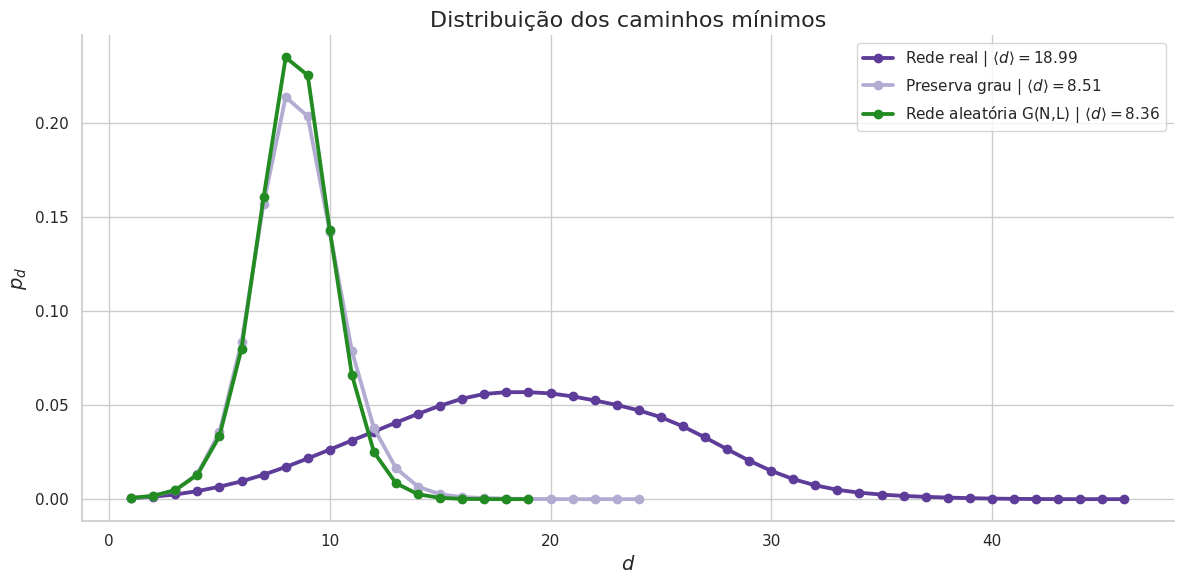

In [13]:
# ============================================
# DISTRIBUIÇÃO DOS CAMINHOS MÍNIMOS
# ============================================
G_real = nx.read_edgelist('powergrid.edgelist.txt')
N = G_real.number_of_nodes()
L = G_real.number_of_edges()
print(f"Rede real: N = {N}, L = {L}")

# Usa apenas o maior componente conexo (para evitar infinito nos caminhos)
G_real = G_real.subgraph(max(nx.connected_components(G_real), key=len)).copy()

# ---------------------------------------
# Função auxiliar: distribuição dos caminhos mínimos
# ---------------------------------------
def shortest_path_distribution(G):
    """
    Calcula a distribuição das distâncias dos caminhos mínimos entre todos os pares de nós de uma rede.

    Parameters
    ----------
    G : networkx.Graph
        Grafo (não direcionado ou direcionado) para o qual a distribuição de caminhos mínimos será calculada.

    Returns
    -------
    distancias : numpy.ndarray
        Vetor com as distâncias (comprimentos dos caminhos mínimos) distintas.
    probs : numpy.ndarray
        Vetor com as probabilidades associadas a cada distância, isto é, a fração de pares de nós
        cuja menor distância é igual a cada valor em `distancias`.
    """
    lengths = []
    for _, lengths_dict in nx.shortest_path_length(G):
        lengths.extend(lengths_dict.values())
    lengths = [d for d in lengths if d > 0]
    count = Counter(lengths)
    distancias = np.array(sorted(count.keys()))
    probs = np.array([count[d] / sum(count.values()) for d in distancias])
    return distancias, probs

def mean_shortest_path(G):
    """
    Calcula o comprimento médio dos caminhos mínimos de uma rede.

    Parameters
    ----------
    G : networkx.Graph
        Grafo (não direcionado ou direcionado) para o qual será calculado o comprimento médio dos caminhos mínimos.

    Returns
    -------
    float
        Valor médio do comprimento dos caminhos mínimos entre todos os pares de nós conectados.
    """
    lengths = []
    for _, lengths_dict in nx.shortest_path_length(G):
        lengths.extend(lengths_dict.values())
    lengths = [d for d in lengths if d > 0]
    return np.mean(lengths)

# ---------------------------------------
# 1. Distribuição da rede real
# ---------------------------------------
d_real, p_real = shortest_path_distribution(G_real)
mean_real = mean_shortest_path(G_real)
print(f"Média dos caminhos mínimos da rede real: ⟨d⟩ = {mean_real:.2f}")

# ---------------------------------------
# 2. Rede aleatória G(N, L) (exatamente L arestas)
# ---------------------------------------
G_rand = nx.gnm_random_graph(N, L)
G_rand = G_rand.subgraph(max(nx.connected_components(G_rand), key=len)).copy()
d_rand, p_rand = shortest_path_distribution(G_rand)
mean_rand = mean_shortest_path(G_rand)
print(f"Média dos caminhos mínimos da rede aleatória G(N,L): ⟨d⟩ = {mean_rand:.2f}")

# ---------------------------------------
# 3. Rede com aleatorização preservando graus
# ---------------------------------------
G_deg = G_real.copy()
nx.double_edge_swap(G_deg, nswap=5*L, max_tries=10*L)
G_deg = G_deg.subgraph(max(nx.connected_components(G_deg), key=len)).copy()
d_deg, p_deg = shortest_path_distribution(G_deg)
mean_deg = mean_shortest_path(G_deg)
print(f"Média dos caminhos mínimos da rede preservando grau: ⟨d⟩ = {mean_deg:.2f}")

# ---------------------------------------
# 4. Gráfico comparativo
# ---------------------------------------
plt.figure(figsize=(12,6))

plt.plot(d_real, p_real, 'o-', lw=2.75, color='#5e3c99',
         label=fr'Rede real | $\langle d \rangle={mean_real:.2f}$')
plt.plot(d_deg, p_deg, 'o-', lw=2.75, color='#b2abd2',
         label=fr'Preserva grau | $\langle d \rangle={mean_deg:.2f}$')
plt.plot(d_rand, p_rand, 'o-', lw=2.75, color='#228b22',
         label=fr'Rede aleatória G(N,L) | $\langle d \rangle={mean_rand:.2f}$')

plt.xlabel(r'$d$', fontsize=14)
plt.ylabel(r'$p_d$', fontsize=14)
plt.title('Distribuição dos caminhos mínimos', fontsize=16)
plt.legend(facecolor='white')
sns.despine()
plt.tight_layout()
plt.show()

A rede real analisada possui 4.941 nós e 6.594 arestas, apresentando uma média de caminhos mínimos ⟨d⟩ = 18,99. Ao compará-la com uma rede aleatória com o mesmo número de nós e arestas, observa-se uma redução significativa da distância média, ⟨d⟩ = 8,46, indicando que a randomização gera uma estrutura mais conectada. De maneira semelhante, a rede gerada por aleatorização que preserva o grau dos nós apresenta ⟨d⟩ = 8,56, valor próximo ao da rede aleatória completa. Esses resultados mostram que a rede real é estruturalmente mais esparsa, com caminhos mais longos, enquanto as redes randomizadas tendem a reduzir significativamente as distâncias médias entre os nós.


# Questão 3

Rede real -> Grau mínimo: 1, Grau máximo: 19
Rede ER -> Grau mínimo médio: 0.00, Grau máximo médio: 10.39


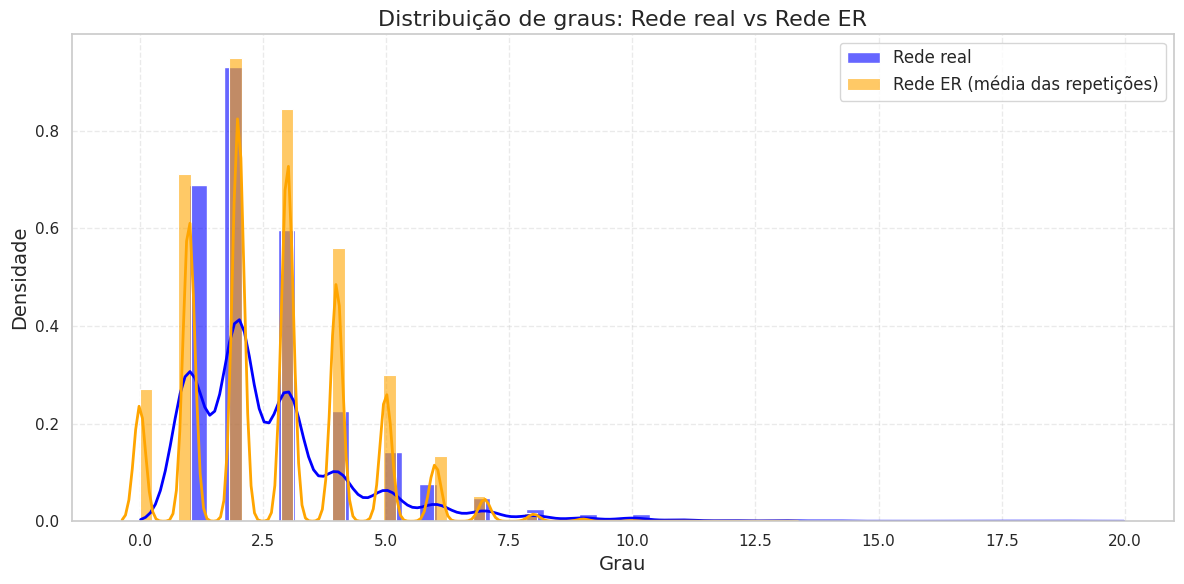

In [12]:
# -------------------------------------------
# 1) Extrai a lista de graus da rede real
# -------------------------------------------
degrees_real = [d for _, d in G_real.degree()]
print(f"Rede real -> Grau mínimo: {min(degrees_real)}, Grau máximo: {max(degrees_real)}")

# -------------------------------------------
# 2) Função para gerar rede Erdős–Rényi G(N, p)
# -------------------------------------------
def generate_ER(N, L):
    """
    Gera uma rede Erdős–Rényi G(N, p) com aproximadamente L arestas.
    Retorna a lista de graus e o grafo gerado.
    """
    p = (2 * L) / (N * (N - 1))  # Probabilidade de cada aresta existir
    G_er = nx.erdos_renyi_graph(N, p)
    degrees = [d for _, d in G_er.degree()]
    return degrees, G_er

# ---------------------------------------------------
# 3) Repetições para calcular o caso médio da rede ER
# ---------------------------------------------------
trials = 100
degrees_er_all = []
min_degree_er = []
max_degree_er = []

for _ in range(trials):
    degrees_er, _ = generate_ER(N, L)
    degrees_er_all.extend(degrees_er)
    min_degree_er.append(min(degrees_er))
    max_degree_er.append(max(degrees_er))

print(f"Rede ER -> Grau mínimo médio: {np.mean(min_degree_er):.2f}, "
      f"Grau máximo médio: {np.mean(max_degree_er):.2f}")

# -------------------------------------------
# 4) Plot das distribuições de grau
# -------------------------------------------
plt.figure(figsize=(12, 6))

# Rede real
sns.histplot(degrees_real, bins=50, color='blue', alpha=0.6, stat="density", label="Rede real")
sns.kdeplot(degrees_real, color='blue', linewidth=2)

# Rede ER (média das repetições)
sns.histplot(degrees_er_all, bins=50, color='orange', alpha=0.6, stat="density", label="Rede ER (média das repetições)")
sns.kdeplot(degrees_er_all, color='orange', linewidth=2)

# Estilo do gráfico
plt.xlabel("Grau", fontsize=14)
plt.ylabel("Densidade", fontsize=14)
plt.title("Distribuição de graus: Rede real vs Rede ER", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

A análise das distribuições de grau e dos caminhos mínimos mostra que a rede real apresenta uma estrutura claramente não aleatória. Sua distribuição de graus é heterogênea, com picos e uma cauda longa, indicando a presença de nós altamente conectados (hubs) e grande variabilidade de conectividade entre os vértices. Já as redes aleatórias exibem distribuições mais regulares, típicas do modelo de Erdős–Rényi. Além disso, a rede real possui caminhos mínimos médios bem maiores, sugerindo uma estrutura mais modular ou segmentada, possivelmente composta por comunidades pouco interligadas. Em contraste, as redes aleatórias — mesmo aquelas que preservam o grau médio — apresentam distâncias médias menores e distribuição mais concentrada. Esses resultados indicam que a rede real é organizada por mecanismos não aleatórios, refletindo propriedades estruturais complexas ausentes nas versões aleatórias.
